In [92]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

from utils.utils import oversample_category, visualize_images, get_image_paths

In [93]:
# Define dataset directory
data_dir = './Dataset_BUSI_with_GT/'

# List of subdirectories (categories)
categories = ['benign', 'malignant', 'normal']

In [94]:
# Count the number of images in each category and display
categories_size = []
for category in categories:
    path = os.path.join(data_dir, category)
    images = os.listdir(path)
    categories_size.append(len(images))
    print(f"Number of {category} images:", len(images))

Number of benign images: 479
Number of malignant images: 212
Number of normal images: 135


In [95]:
# Initialize the data generator with desired augmentations
aug_datagen = ImageDataGenerator()

In [96]:
# For each category, call the oversample_category function
max_size = max(categories_size)
benign_oversampled = oversample_category(os.path.join(data_dir, categories[0]), max_size, aug_datagen)
malignant_oversampled = oversample_category(os.path.join(data_dir, categories[1]), max_size, aug_datagen)
normal_oversampled = oversample_category(os.path.join(data_dir, categories[2]), max_size, aug_datagen)

['./Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (204).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (138).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (150).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (64).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (129).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (72).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (165).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (10).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (5).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (67).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (134).png', './Dataset_BUSI_with_GT/malignant/oversampled/oversampled_malignant (17).png', './Dataset_BUSI_with_GT/malignant/oversampled/

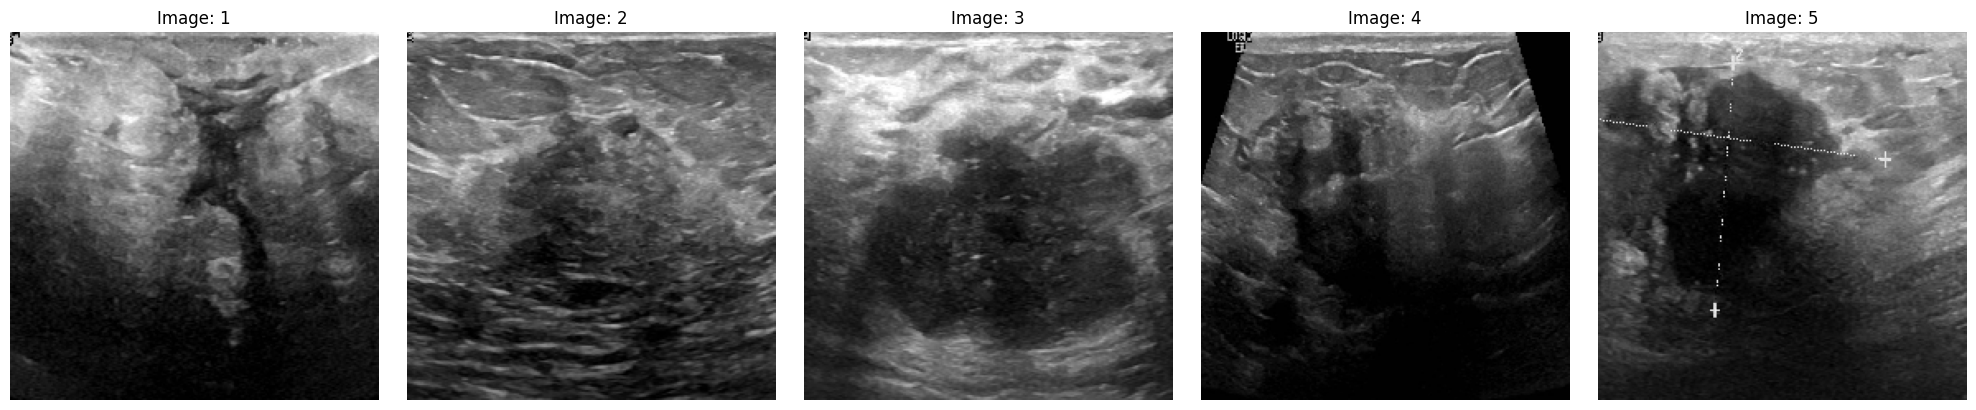

479 478 473


In [97]:
print(malignant_oversampled)
visualize_images(malignant_oversampled)
print(len(benign_oversampled), len(malignant_oversampled), len(normal_oversampled))

In [98]:
combined_data = {}

# Iterate through each category to gather original image paths and combine them with oversampled paths
for category in categories:
    category_path = os.path.join(data_dir, category)
    original_image_paths = [os.path.join(category_path, image) for image in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, image)) and image.endswith('.png')]

    # Combine the original and oversampled paths
    combined_data[category] = original_image_paths

combined_data['malignant'].extend(malignant_oversampled)
combined_data['normal'].extend(normal_oversampled)
print(combined_data)

{'benign': ['./Dataset_BUSI_with_GT/benign/benign (328).png', './Dataset_BUSI_with_GT/benign/benign (282).png', './Dataset_BUSI_with_GT/benign/benign (144).png', './Dataset_BUSI_with_GT/benign/benign (82).png', './Dataset_BUSI_with_GT/benign/benign (390).png', './Dataset_BUSI_with_GT/benign/benign (113).png', './Dataset_BUSI_with_GT/benign/benign (406).png', './Dataset_BUSI_with_GT/benign/benign (369).png', './Dataset_BUSI_with_GT/benign/benign (386).png', './Dataset_BUSI_with_GT/benign/benign (105).png', './Dataset_BUSI_with_GT/benign/oversampled_benign (244).png', './Dataset_BUSI_with_GT/benign/benign (410).png', './Dataset_BUSI_with_GT/benign/benign (294).png', './Dataset_BUSI_with_GT/benign/benign (152).png', './Dataset_BUSI_with_GT/benign/benign (94).png', './Dataset_BUSI_with_GT/benign/benign (200).png', './Dataset_BUSI_with_GT/benign/benign (345).png', './Dataset_BUSI_with_GT/benign/oversampled_benign (287).png', './Dataset_BUSI_with_GT/benign/benign (129).png', './Dataset_BUSI_

In [99]:
# Create a DataFrame for the combined dataset
data_entries = []
for class_name, image_paths in combined_data.items():
    for image_path in image_paths:
        data_entries.append({'filename': image_path, 'class': class_name})

image_df = pd.DataFrame(data_entries)

In [100]:
# Split the data into training plus validation and test sets 
train_val_df, test_df = train_test_split(image_df, test_size=0.2, stratify=image_df['class'], random_state=42)

# Split the training plus validation set into separate training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['class'], random_state=42)
print(train_df)

                                               filename      class
663   ./Dataset_BUSI_with_GT/malignant/malignant (17...  malignant
1002  ./Dataset_BUSI_with_GT/malignant/malignant (46...  malignant
703   ./Dataset_BUSI_with_GT/malignant/oversampled/o...  malignant
857   ./Dataset_BUSI_with_GT/malignant/oversampled/o...  malignant
144      ./Dataset_BUSI_with_GT/benign/benign (142).png     benign
...                                                 ...        ...
261      ./Dataset_BUSI_with_GT/benign/benign (357).png     benign
275       ./Dataset_BUSI_with_GT/benign/benign (90).png     benign
890   ./Dataset_BUSI_with_GT/malignant/oversampled/o...  malignant
1672     ./Dataset_BUSI_with_GT/normal/normal (109).png     normal
483   ./Dataset_BUSI_with_GT/malignant/malignant (21...  malignant

[1062 rows x 2 columns]


In [101]:
# Initialize the data generator with desired augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

Found 1059 validated image filenames belonging to 3 classes.


/Users/erikamolnar/Anaconda/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [102]:
# ImageDataGenerator for validation and test sets with only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create the data generator for the validation set
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # Do not shuffle the validation data
)

# Create the data generator for the test set
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # Do not shuffle the test data
)


Found 353 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.


/Users/erikamolnar/Anaconda/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


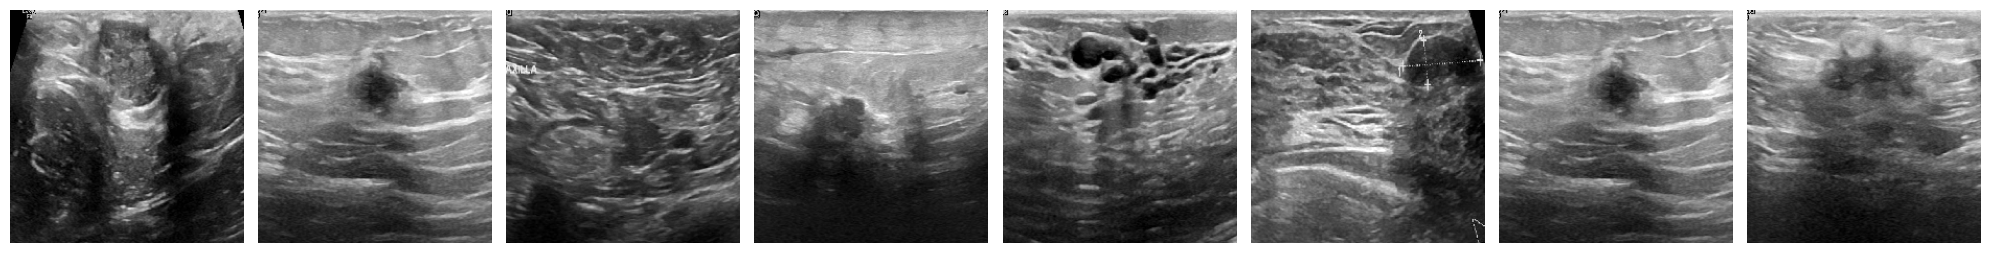

In [103]:
# Get a batch of images
x_batch, y_batch = next(test_generator)

# Define the number of images to show and set up the figure
num_images = 8
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

# Plot the images
for i, ax in enumerate(axes):
    image = np.clip(x_batch[i] * 255, 0, 255).astype('uint8')
    ax.imshow(image.astype('uint8'), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [104]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # Extract class names

# Initialize a dictionary to hold the counts
class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the classes array and count each class's occurrences
for class_index in train_generator.classes:
    class_name = class_names[class_index]
    class_counts[class_name] += 1

print(class_counts)

{'benign': 286, 'malignant': 410, 'normal': 363}


In [105]:
# MobileNet expects three channels
input_shape = (224, 224, 3)

input_image = Input(shape=(224, 224, 1))

# Lambda layer to replicate the grayscale channel
x = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(input_image)

# MobileNet model, pre-trained on ImageNet, without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=x)

# Freeze the layers of the base model
base_model.trainable = True

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=input_image, outputs=x)

N = 20  # Unfreeze the last 20 layers
for layer in base_model.layers[:-N]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda_6 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                         

/Users/erikamolnar/Anaconda/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [106]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
33/33 [==============================] - 14s 391ms/step - loss: 1.2996 - accuracy: 0.4499 - val_loss: 1.2077 - val_accuracy: 0.3807 - lr: 1.0000e-05
Epoch 2/50
33/33 [==============================] - 11s 327ms/step - loss: 0.9575 - accuracy: 0.5745 - val_loss: 1.0906 - val_accuracy: 0.5170 - lr: 1.0000e-05
Epoch 3/50
33/33 [==============================] - 11s 330ms/step - loss: 0.7975 - accuracy: 0.6660 - val_loss: 1.0409 - val_accuracy: 0.6051 - lr: 1.0000e-05
Epoch 4/50
33/33 [==============================] - 11s 333ms/step - loss: 0.6803 - accuracy: 0.7176 - val_loss: 0.9517 - val_accuracy: 0.6364 - lr: 1.0000e-05
Epoch 5/50
33/33 [==============================] - 11s 350ms/step - loss: 0.5767 - accuracy: 0.7838 - val_loss: 0.8856 - val_accuracy: 0.6733 - lr: 1.0000e-05
Epoch 6/50
33/33 [==============================] - 11s 342ms/step - loss: 0.5728 - accuracy: 0.7751 - val_loss: 0.7923 - val_accuracy: 0.6960 - lr: 1.0000e-05
Epoch 7/50
33/33 [======================

12/12 [==============================] - 3s 231ms/step - loss: 0.3321 - accuracy: 0.8986


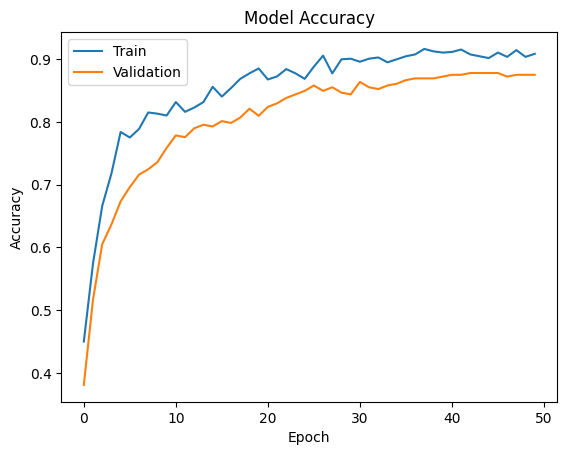

In [107]:
test_loss, test_acc = model.evaluate(test_generator)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [108]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

12/12 [==============================] - 3s 211ms/step


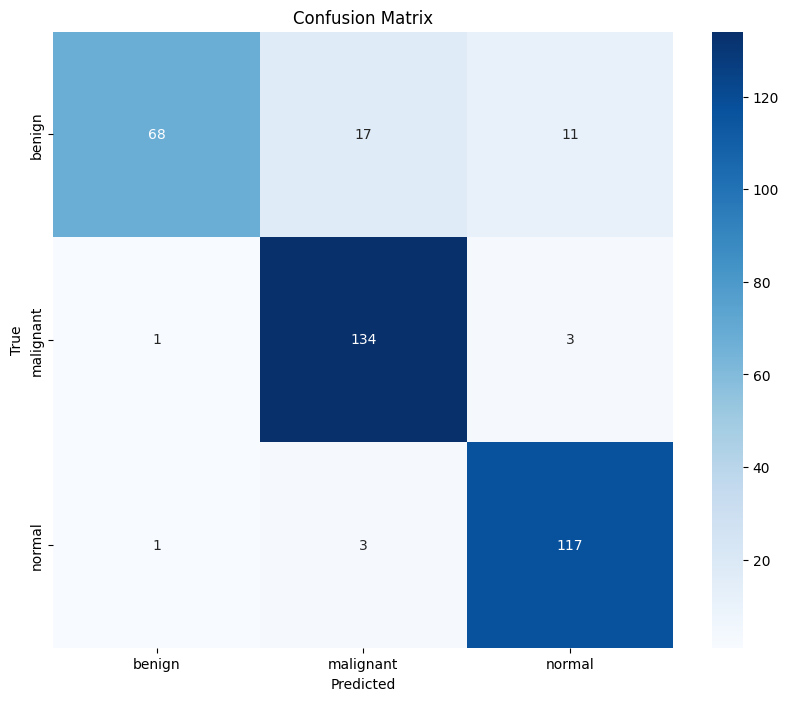

In [109]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [110]:
# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

      benign       0.97      0.71      0.82        96
   malignant       0.87      0.97      0.92       138
      normal       0.89      0.97      0.93       121

    accuracy                           0.90       355
   macro avg       0.91      0.88      0.89       355
weighted avg       0.91      0.90      0.89       355



In [111]:
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 89.86%
